<a href="https://colab.research.google.com/github/milin2109/Machine-Learning-Workbook/blob/main/Advertising_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advertising Analysis**
- Dataset: small with around 200 points
- Business Problem: Try to predict Sales based on advertising budgets from TV, radio & newspaper media

## **Import Libraries:**


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [61]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## **Load Dataset**

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("drive/My Drive/ColabNotebooks/Python_Practice_Notebook/Linear_Regression/dataset/Advertising.csv")
df.head()

Mounted at /content/drive


,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


In [6]:
df.describe()

,TV,radio,newspaper,sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


**Insights:**
- There's all numerical values (with diferrent scale) and the dataset is very small

## **Exploratory Data Analysis**

### Independent Variables:

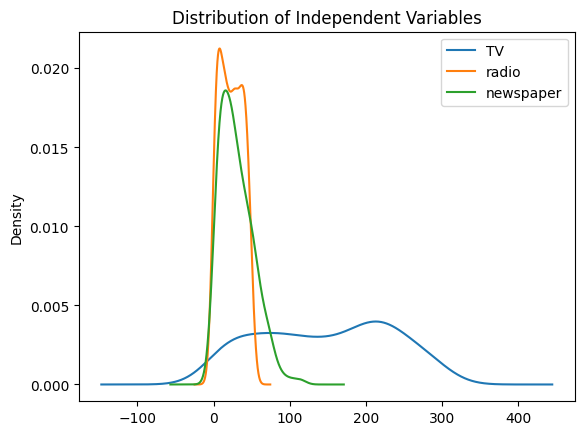

In [7]:
df['TV'].plot(kind='kde')
df['radio'].plot(kind='kde')
df['newspaper'].plot(kind='kde')
plt.title('Distribution of Independent Variables')
plt.legend();

**Insights:**
- Overall, TV & Radio distribution is not followed Normal, except for Newspaper which has a right skew (mean > median)
- TV data is pretty sparse, with data is all around the place and not concentrated on one specific peak

## Target Variable

Text(0.5, 1.0, 'Distribution of Target Variables')

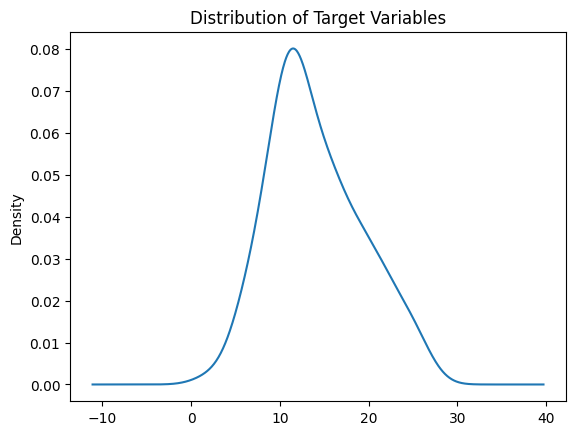

In [8]:
df['sales'].plot(kind='kde')
plt.title('Distribution of Target Variables')

**Insights:**
- Target Varaible has a Bell curved and looks Normal Distribution, with a right skew (mean > median)

## Relationship between Target & Independent Variables:

<Axes: >

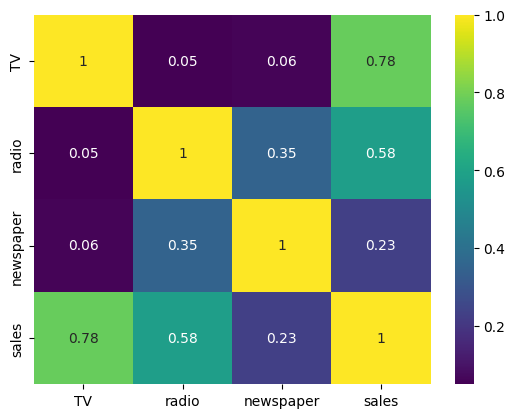

In [9]:
sns.heatmap(df.corr().round(2), annot=True, cmap = 'viridis')

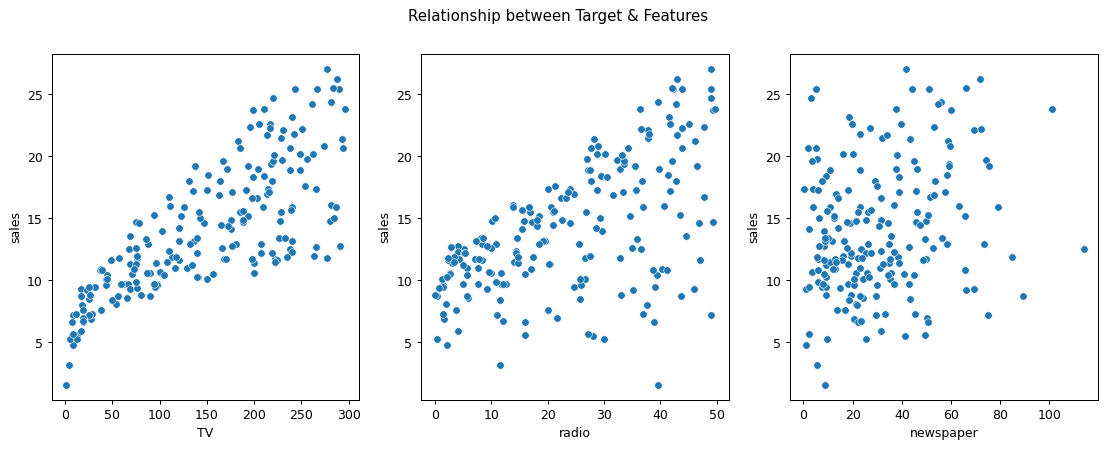

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (5 * 3,  5), dpi = 90)
sns.scatterplot(data=df, x='TV', y='sales',ax=ax[0])
sns.scatterplot(data=df, x='radio', y='sales',ax=ax[1])
sns.scatterplot(data=df, x='newspaper', y='sales',ax=ax[2])
plt.suptitle('Relationship between Target & Features');

**Insights:**
- According to both correlation matrix & scatterplot, we can see that **TV** has the strongest positive correlation to Sales (0.78), while **radio** also has a moderate positive relationshop to Sales (0.58)
- However, **newspaper** has a rather weak positive relationship and there are no visibly trend to be spotted in scatterplot
- There's no strong correlationship between independent variables
- There are 2 outliers that can be visible in scatterplot for newspaper (>= 100)

## **Data Preprocessing**

### Mising Values

In [11]:
df.isnull().sum()
# There's no null values

TV           0
radio        0
newspaper    0
sales        0
dtype: int64

### Outliers
- should only be applied for training dataset; to avoid data leakage

In [12]:
# Detect outliers using IQR
def detect_outliers(X_train, y_train, columns):
  df = pd.concat([X_train, y_train], axis=1)
  data = df[columns]

  q1, q3 = np.percentile(data, [25,75])
  IQR = q3 - q1
  lower_bound = q1 - 1.5 * IQR
  upper_bound = q3 + 1.5 * IQR
  outliers = data[(data <= lower_bound) | (data >= upper_bound)]
  print(f'Outliers Percent for {columns}: {len(outliers)/len(data)*100}')
  return outliers


## **Feature Engineering**

### Scaling:
- Values are on different scale. Need to scale Independent Variables

In [13]:
cols_to_scale = ['TV', 'radio', 'newspaper']

scaler = MinMaxScaler()

scaler_transformer = ColumnTransformer(
    transformers = [('scaler_transformer', scaler, cols_to_scale)],
    verbose_feature_names_out= False,
    remainder='passthrough'
).set_output(transform = "pandas")

### Transformation:
- No need since there's no cat features

## **Train Model**


In [14]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(160, 3) (40, 3) (160,) (40,)


### Remove/Impute outliers

In [15]:
outliers = {}

for cols in pd.concat([X_train, y_train], axis=1).columns:
  outliers[cols] = detect_outliers(X_train, y_train, cols)

Outliers Percent for TV: 0.0
Outliers Percent for radio: 0.0
Outliers Percent for newspaper: 0.625
Outliers Percent for sales: 0.0


In [16]:
X_train[X_train['newspaper'].isin(outliers['newspaper'])]

,TV,radio,newspaper
101,296.4,36.3,100.9


In [17]:
y_train[X_train['newspaper'].isin(outliers['newspaper'])]

101    23.8
Name: sales, dtype: float64

**Insights**:
- The outlies seem pretty logical here -> cann't determine -> keep and not drop

### Scaling:

In [18]:
# For practice purpose using pipeline
pipe = Pipeline([
    ('scaler', scaler_transformer)
    ])
X_train_scaled = pipe.fit_transform(X_train)
X_train_scaled.shape

(160, 3)

## **Check statistical Model**

### 1. Use statsmodels.formula.api:
- Need to combine X_train & y_train into 1 dataframe
- Need to specify the formula: Y ~ X1 + X2
- But already include intercept value

In [20]:
# Test
df_test = pd.concat([X_train, y_train], axis=1)
df_test = df_test.rename(columns={'0':'sales'})
df_test.head()

,TV,radio,newspaper,sales
79,116.0,7.7,23.1,11.0
197,177.0,9.3,6.4,12.8
38,43.1,26.7,35.1,10.1
24,62.3,12.6,18.3,9.7
122,224.0,2.4,15.6,11.6


In [21]:
# Use X_train for testing purpose
est_test = smf.ols(formula = 'sales ~ TV + radio + newspaper', data=df_test).fit()
print(est_test.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     446.6
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           2.53e-76
Time:                        07:05:57   Log-Likelihood:                -306.64
No. Observations:                 160   AIC:                             621.3
Df Residuals:                     156   BIC:                             633.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9791      0.354      8.427      0.0

### 2. Use statsmodels.api
- Need to add constant (intercept) to the model

In [22]:
# By default the OLS does not add constant (intercept) to the model -> which will result into uncentered R^2 (diferent formula)
# Use X_train_scaled to see the difference

X_train_sm = sm.add_constant(X_train_scaled)

est_test = sm.OLS(y_train, X_train_sm).fit()
print(est_test.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     446.6
Date:                Fri, 12 Jan 2024   Prob (F-statistic):           2.53e-76
Time:                        07:05:57   Log-Likelihood:                -306.64
No. Observations:                 160   AIC:                             621.3
Df Residuals:                     156   BIC:                             633.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0112      0.352      8.553      0.0

#### **NOTES**:
- model result in Uncentered R^2 is a linear model without intercept.
- The formula for calculating R^2 is different from "Centered" one (Normal R^2):
  - *Uncentered*: `1 - (((y - y_pred) ** 2).sum() / (y ** 2).sum())`
  - *Centered*:   `1 - (((y - y_pred) ** 2).sum() / ((y - np.mean(y)) ** 2).sum())`
- Same result between 2 different ways
- Using **X_train_scaled** -> results in a more normal distribution

## **Model 1: Linear Regression**

In [23]:
# Function to evaluate performance
def evaluate_score(model, X_test, y_test):
  y_preds = model.predict(X_test)
  rmse = np.sqrt(mean_squared_error(y_test, y_preds))
  r2 = r2_score(y_test, y_preds)
  print(f'RMSE: {rmse} \nR2: {r2 * 100}' )
  return rmse, r2

In [24]:
# Baseline y_test mean to compare with rmse
y_test_mean = y_test.mean()
y_train_mean = y_train.mean()
y_test_mean, y_train_mean

(13.7125, 14.1)

### Baseline Model
- Run Simple Regression Model without tunning, and use them as baseline to compare all other models

In [25]:
lin_reg_baseline_model = LinearRegression(fit_intercept=True)
lin_reg_baseline_model.fit(X_train_scaled, y_train)

# Calculating perfromance on train set
rmse_reg_baseline, r2_reg_baseline = evaluate_score(lin_reg_baseline_model, X_train_scaled, y_train)
print(f'Percent Train rmse compared to mean: {rmse_reg_baseline/y_train_mean * 100}')

RMSE: 1.644727765644337 
R2: 89.57008271017818
Percent Train rmse compared to mean: 11.664735926555583


### Leave-one-out CV Model
- Since our sample size is very small -> it may be not neccessary to use K-Fold CV and spit them to specific folds. However, we can run **Leave-on-out** method on this to make sure it's not overfit

In [26]:
reg_loo_scores = cross_validate(LinearRegression(fit_intercept=True), X_train_scaled, y_train, scoring = 'neg_mean_squared_error', cv = len(X_train_scaled), n_jobs=-1, verbose = 2, return_train_score=True)
reg_loo_scores = pd.DataFrame(reg_loo_scores)
reg_loo_scores

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.8s finished


,fit_time,score_time,test_score,train_score
0,0.026686,0.004661,-1.768567,-2.711172
1,0.019765,0.012785,-0.016598,-2.722040
2,0.013218,0.002424,-0.002066,-2.722130
3,0.011576,0.015897,-2.324857,-2.707759
4,0.015276,0.006133,-3.773735,-2.698983
...,...,...,...,...
155,0.003690,0.012240,-0.926664,-2.716455
156,0.004542,0.013477,-0.299756,-2.720283
157,0.004527,0.006631,-0.034844,-2.721929
158,0.004303,0.019743,-0.076432,-2.721668


In [27]:
reg_loo_train_rmse = np.sqrt(abs(reg_loo_scores['train_score']).mean())
reg_loo_test_rmse = np.sqrt(abs(reg_loo_scores['test_score']).mean())
print(f'Train RMSE: {reg_loo_train_rmse}. Test RMSE: {reg_loo_test_rmse}')

Train RMSE: 1.6445275750874095. Test RMSE: 1.7085573452246177


## **Model 2: Polynomial Regression Model:**
 Perhaps a higher order would improve performance even more! But how high is too high?

Let's use a for loop to do the following:

1. Create different order polynomial X data
2. Split that polynomial data for train/test
3. Fit on the training data
4. Report back the metrics on *both* the train and test results
5. Plot these results and explore overfitting

In [28]:
# Function to test al degree

def poly_reg_degree_choose(X, y):
  for d in range(1,10):
    poly_transformer = PolynomialFeatures(degree = d, include_bias=False)
    poly_X = poly_transformer.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(poly_X, y, test_size=0.2, random_state=42)
    scaler = MinMaxScaler()
    X_train_poly_scaled = scaler.fit_transform(X_train)

    polyreg_loo_scores = cross_validate(LinearRegression(fit_intercept=True), X_train_poly_scaled, y_train, scoring = 'neg_mean_squared_error', cv = len(X_train_poly_scaled), n_jobs=-1, verbose = 2, return_train_score=True)
    polyreg_loo_scores = pd.DataFrame(polyreg_loo_scores)

    polyreg_loo_train_rmse = np.sqrt(abs(polyreg_loo_scores['train_score']).mean())
    polyreg_loo_test_rmse = np.sqrt(abs(polyreg_loo_scores['test_score']).mean())

    train_rmse_reg_scores.append(polyreg_loo_train_rmse)
    test_rmse_reg_scores.append(polyreg_loo_test_rmse)

  return train_rmse_reg_scores, test_rmse_reg_scores


In [29]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]
train_rmse_reg_scores = []
test_rmse_reg_scores = []

train_rmse_scores, test_rmse_reg_scores = poly_reg_degree_choose(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 157 out of 160 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 out o

''

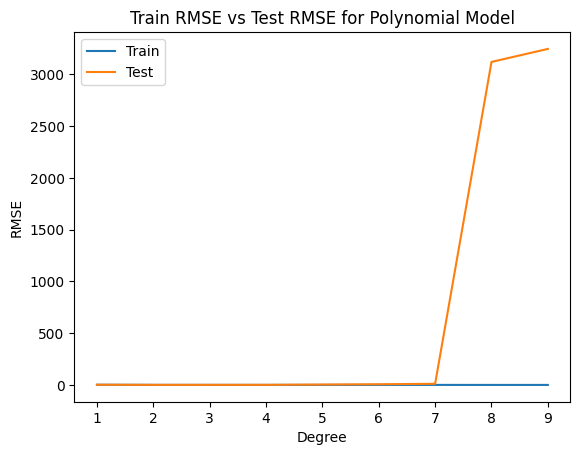

In [30]:
plt.plot(range(1,10), train_rmse_reg_scores, label = 'Train')
plt.plot(range(1,10), test_rmse_reg_scores, label = 'Test')
plt.title('Train RMSE vs Test RMSE for Polynomial Model')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.legend()
;

''

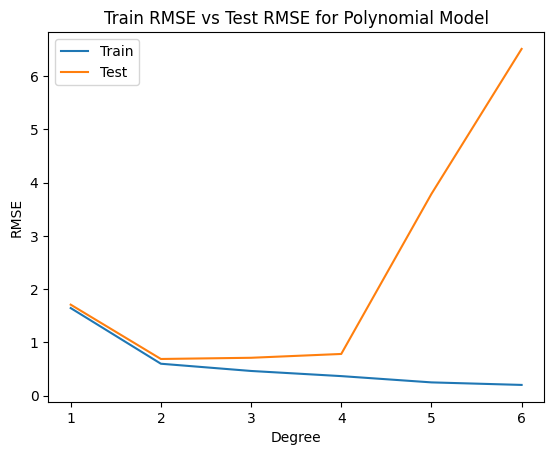

In [31]:
# Limit graph to degree 1-6
plt.plot(range(1,7), train_rmse_reg_scores[:6], label = 'Train')
plt.plot(range(1,7), test_rmse_reg_scores[:6], label = 'Test')
plt.title('Train RMSE vs Test RMSE for Polynomial Model')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.legend()
;

**Insights**
- According to the graph & actual value, we can see the test RMSE skyrocketed from degree 4 to all the way to degree 10.
- The Train RMSE begins to decline at degree 2 -> create an elbow curve there, at the same time, the Test RMSE at degree 2 also decline.

<br>As a result, go with degree = 2, which will generate the best results to test Regularization Method

In [32]:
# Create a new degree train, test dataset

poly_transformer = PolynomialFeatures(degree = 2, include_bias=False)
poly_X = poly_transformer.fit_transform(X)

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(poly_X, y, test_size=0.2, random_state=42)
poly_scaler = MinMaxScaler()
X_train_poly_scaled = poly_scaler.fit_transform(X_train_poly)

In [33]:
print(X_train_poly.shape, X_test_poly.shape, y_train_poly.shape, y_test_poly.shape)

(160, 9) (40, 9) (160,) (40,)


## **Regularization**

In [34]:
param_grid = {
   'alpha': [0, 0.01, 0.02, 0.05, 0.1, 1, 2, 5, 10, 20, 50],
   'l1_ratio': [0, 0.1, 0.3, 0.5, 0.9, 0.99, 1],
   'max_iter': [10000],
   'random_state': [42]
}

en_model = ElasticNet()
en_cv_model = GridSearchCV(estimator=en_model, param_grid=param_grid,cv=len(X_train_poly_scaled),scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1,verbose=2)
en_cv_model.fit(X_train_poly_scaled, y_train_poly)

Fitting 160 folds for each of 77 candidates, totalling 12320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.883e+01, tolerance: 4.150e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_c

GridSearchCV(cv=160, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0, 0.01, 0.02, 0.05, 0.1, 1, 2, 5, 10, 20,
                                   50],
                         'l1_ratio': [0, 0.1, 0.3, 0.5, 0.9, 0.99, 1],
                         'max_iter': [10000], 'random_state': [42]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [35]:
print(en_cv_model.best_params_)
print(en_cv_model.best_score_)
print(np.sqrt(abs(en_cv_model.best_score_).mean()))

{'alpha': 0, 'l1_ratio': 0, 'max_iter': 10000, 'random_state': 42}
-0.4750962804576476
0.6892722832507104


## **Model 3: SVM**
#### When to use:
1. High sparsity & high number of features
2. Small dataset
3. Deal with non-linearity

In [36]:
# Baseline SVR Model
svr = SVR()
svr.fit(X_train_scaled, y_train)
rmse_svr_baseline, r2_svr_baseline = evaluate_score(svr, X_train_scaled, y_train)

RMSE: 1.3628743790165638 
R2: 92.83849217608643


### Hyperparameters Tuning

In [ ]:
param_grid = {
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2,3,4,5,6],
    'C': [0.1, 1, 5, 9, 10], #smaller C, higher margin
    'gamma': ['scaled', 'auto'], #smaller gamma, more flexible model (used with non-linear model)
    'epsilon': [0, 0.01, 0.1, 0.5, 1, 10] #larger epsilon, more tolerance for errors
}

svr_cv_model = GridSearchCV(estimator=SVR(), param_grid=param_grid,cv=len(X_train_scaled),scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1,verbose=2)
svr_cv_model.fit(X_train_scaled, y_train)

Fitting 160 folds for each of 720 candidates, totalling 115200 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
57600 fits failed out of a total of 115200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
28910 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 180, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ut

GridSearchCV(cv=160, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10], 'degree': [2, 3, 4, 5, 6],
                         'epsilon': [0, 0.01, 0.1, 0.5, 1, 10],
                         'gamma': ['scaled', 'auto'],
                         'kernel': ['linear', 'rbf', 'poly']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [ ]:
print(svr_cv_model.best_params_)
print(svr_cv_model.best_score_)
print(np.sqrt(abs(svr_cv_model.best_score_).mean()))

{'C': 10, 'degree': 2, 'epsilon': 0, 'gamma': 'auto', 'kernel': 'rbf'}
-0.8238101919852026
0.9076399021556967


In [51]:
# Try out more value for C

param_grid = {
    'kernel': ['rbf'],
    'degree': [2,3,5],
    'C': [10, 20, 25, 30, 40, 50, 100, 200, 220, 250, 300, 400, 500, 700, 900, 1000], #smaller C, higher margin
    'gamma': ['auto'], #smaller gamma, more flexible model (used with non-linear model)
    'epsilon': [0] #larger epsilon, more tolerance for errors
}

svr_cv_model_test = GridSearchCV(estimator=SVR(), param_grid=param_grid,cv=len(X_train_scaled),scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1,verbose=2)
svr_cv_model_test.fit(X_train_scaled, y_train)

Fitting 160 folds for each of 48 candidates, totalling 7680 fits


GridSearchCV(cv=160, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [10, 20, 25, 30, 40, 50, 100, 200, 220, 250, 300,
                               400, 500, 700, 900, 1000],
                         'degree': [2, 3, 5], 'epsilon': [0], 'gamma': ['auto'],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [52]:
print(svr_cv_model_test.best_params_)
print(svr_cv_model_test.best_score_)
print(np.sqrt(abs(svr_cv_model_test.best_score_).mean()))

{'C': 900, 'degree': 2, 'epsilon': 0, 'gamma': 'auto', 'kernel': 'rbf'}
-0.3785721293881743
0.6152821542903502


## **Model 4: Decision Tree**

In [56]:
# Baseline Tree Model
tree_model = DecisionTreeRegressor(random_state = 42)
tree_model.fit(X_train, y_train)
rmse_dt_baseline, r2_dt_baseline = evaluate_score(tree_model, X_train, y_train)

RMSE: 0.0 
R2: 100.0


**Insights**
- Baseline Model looks **OVERFIT** !!!!


### Hyperparamer Tunning

In [60]:
param_grid = {
    'criterion': ['squared_error', 'absolute_error'],
    'splitter': ['best', 'random'],
    'max_depth': [2, 5, 10, 15, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42]
}

dt_cv_model = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=param_grid,cv=len(X_train),scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1,verbose=2)
dt_cv_model.fit(X_train, y_train)

Fitting 160 folds for each of 576 candidates, totalling 92160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


GridSearchCV(cv=160, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 5, 10, 15, 20, 30, 40, 50],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 5, 10, 15, 20],
                         'random_state': [42], 'splitter': ['best', 'random']},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=2)

In [62]:
print(dt_cv_model.best_params_)
print(dt_cv_model.best_score_)
print(np.sqrt(abs(dt_cv_model.best_score_).mean()))

{'criterion': 'absolute_error', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 1, 'random_state': 42, 'splitter': 'best'}
-1.4966875
1.2233918015092302


## **Model 5: Random Forest**

In [64]:
# RandomForest Model
rf_model = RandomForestRegressor(random_state = 42)
rf_model.fit(X_train, y_train)
rmse_rf_baseline, r2_rf_baseline = evaluate_score(rf_model, X_train, y_train)

RMSE: 0.30780258486568945 
R2: 99.63471037158416


### Hyperparameter Tunning

In [ ]:
param_grid = {
    'n_estimators': [1, 2, 5, 10, 15, 20, 30, 50, 100],
    'criterion': ['squared_error', 'absolute_error'],
    'max_depth': [2, 5, 10, 15, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10, 15, 20],
    'max_features': ['auto', 'sqrt', 'log2'],
    'random_state': [42],
    'bootstrap': [True, False],
    'oob_score': [True, False]
}

rf_cv_model = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid,cv=len(X_train),scoring='neg_mean_squared_error', return_train_score=True, n_jobs=-1,verbose=2)
rf_cv_model.fit(X_train, y_train)

Fitting 160 folds for each of 10368 candidates, totalling 1658880 fits


In [ ]:
print(rf_cv_model.best_params_)
print(rf_cv_model.best_score_)
print(np.sqrt(abs(rf_cv_model.best_score_).mean()))

## **Evaluate Model**

## **Model 2: Polynomial Regression Model**

In [ ]:
# Prepare test set
X_test_poly_scaled = poly_scaler.transform(X_test_poly)
rmse_poly_reg, r2_poly_reg = evaluate_score(en_cv_model, X_test_poly_scaled, y_test_poly)

RMSE: 0.6425809120553642 
R2: 98.69181490609603


## **Model 3: SVM**

In [54]:
X_test_scaled = pipe.transform(X_test)
rmse_svr, r2_svr = evaluate_score(svr_cv_model_test, X_test_scaled, y_test)

RMSE: 0.5779133356895065 
R2: 98.94187009814821


## **Model 4: Decision Tree**

In [63]:
rmse_dt, r2_dt = evaluate_score(dt_cv_model, X_test, y_test)

RMSE: 1.494908023926556 
R2: 92.91984931215255


## **Model 5: Random Forest**

In [ ]:
rmse_rf, r2_rf = evaluate_score(rf_cv_model, X_test, y_test)

## **Conclustion**: